In [121]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import zipfile
import os

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [135]:
full_data = pd.read_csv('cook_county_train.csv')
full_data = log_transform(full_data, 'Sale Price')

process_pipeline = [
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (add_bedrooms, None, None)
]


In [159]:
train, valid = train_val_split(full_data)

In [161]:
X_train, y_train =process_data_pipe(train, process_pipeline, 'Log Sale Price')
X_test, y_test = process_data_pipe(validation, process_pipeline, 'Log Sale Price')

In [162]:
X_train.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 
                'Estimate (Land)', 'Estimate (Building)'
               ], axis=1, inplace=True)

X_test.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 
                'Estimate (Land)', 'Estimate (Building)'
               ], axis=1, inplace=True)

In [165]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
input_dim = X_train.shape[1]

In [167]:
def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [169]:
def build_model(num_layers, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)), Dense(64, activation = 'relu'))

    for _ in range(num_layers - 1):
        model.add(Dense(64, activation = 'relu'))

    model.add(Dense(1, activation = 'linear'))
    model.compile(
        optimizer = Adam(learning_rate = 0.001),
        loss = rmse_loss,
        metrics = [tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [171]:
layer_options = [5, 6, 7, 8, 9, 10]
results = []

early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error', 
    patience=5,      
    restore_best_weights=True,
)

for num_layers in layer_options:
    model = build_model(num_layers, input_dim = X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs = 15,
        batch_size = 32,
        validation_split = 0.1,
        callbacks=[early_stopping],
        verbose = 0
    )
    final_val_loss = history.history['val_loss'][-1]
    final_val_rmse  = history.history['val_root_mean_squared_error'][-1]

    results.append((num_layers, final_val_rmse))
for (layers, rmse) in results:
    print(f"Layers: {layers} | Final Val RMSE: {rmse:.4f}")

best_config = min(results, key=lambda x: x[1])
print(f"\nBest configuration based on validation loss: {best_config[0]} layers")

Layers: 5 | Final Val RMSE: 0.5244
Layers: 6 | Final Val RMSE: 0.5952
Layers: 7 | Final Val RMSE: 0.5323
Layers: 8 | Final Val RMSE: 0.5740
Layers: 9 | Final Val RMSE: 0.5398
Layers: 10 | Final Val RMSE: 0.5376

Best configuration based on validation loss: 5 layers


In [177]:
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'linear')
])

early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error', 
    patience=5,      
    restore_best_weights=True,
)
model.compile(optimizer = 'adam', loss = rmse_loss, metrics = [tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=75, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

# 7. Evaluating the Model
loss, rmse = model.evaluate(X_test, y_test)
print("Test RMSE:", rmse)

Epoch 1/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 4s 812us/step - loss: 1.3825 - root_mean_squared_error: 1.9637 - val_loss: 0.4886 - val_root_mean_squared_error: 0.6421
Epoch 2/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 3s 782us/step - loss: 0.4374 - root_mean_squared_error: 0.6251 - val_loss: 0.4691 - val_root_mean_squared_error: 0.6151
Epoch 3/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 3s 754us/step - loss: 0.3698 - root_mean_squared_error: 0.6007 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5600
Epoch 4/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 3s 799us/step - loss: 0.3638 - root_mean_squared_error: 0.6144 - val_loss: 0.3434 - val_root_mean_squared_error: 0.5557
Epoch 5/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 3s 759us/step - loss: 0.3328 - root_mean_squared_error: 0.5792 - val_loss: 0.2869 - val_root_mean_squared_error: 0.5448
Epoch 6/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 3s 788us/step - loss: 0.3266 - root_mean_squared_error: 0.5874 - val_loss: 0.2624 - val_root_mean_squared_error: 0.5341
Epoch 7/75
4096/4096 ━━━━━━━

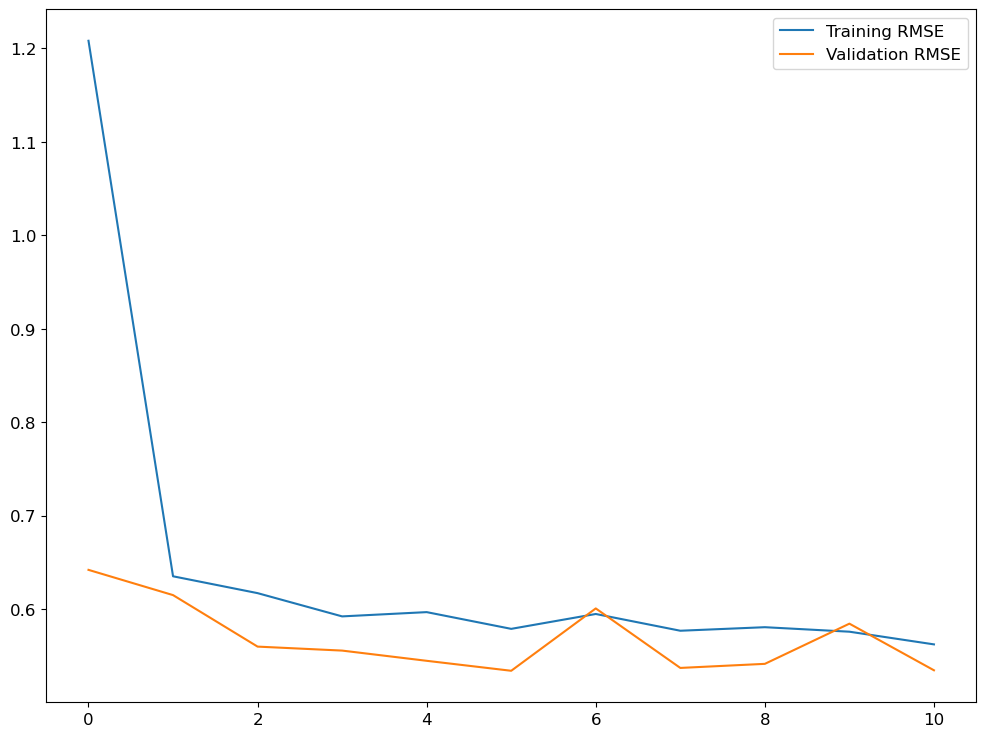

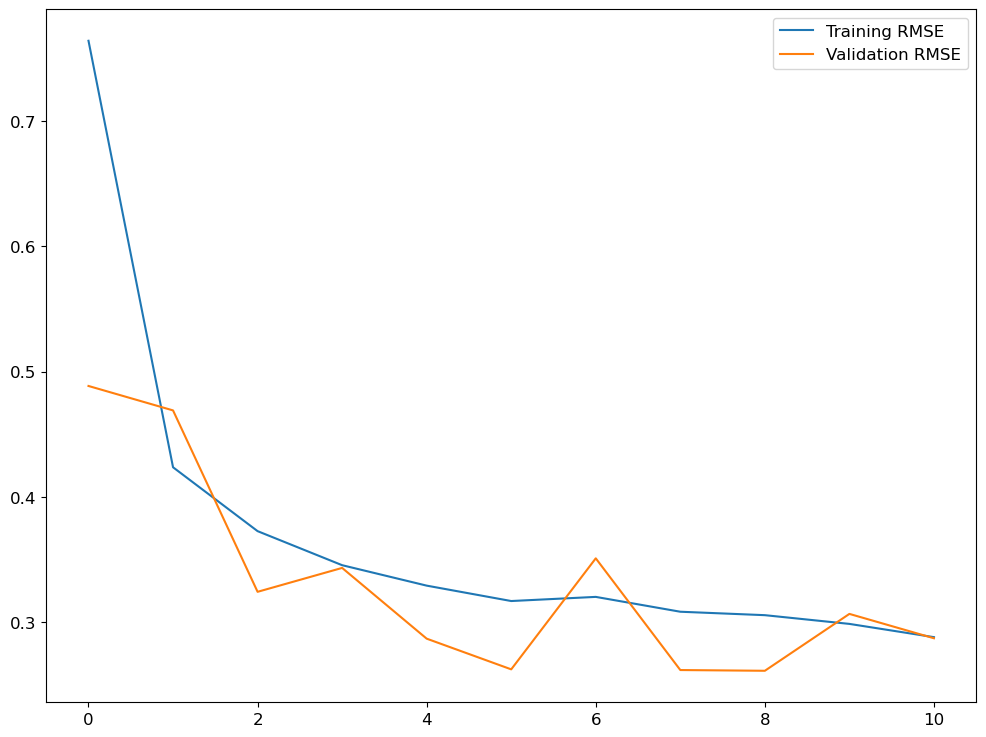

In [179]:
import matplotlib.pyplot as plt
# If using RMSE metric:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training RMSE')
plt.plot(history.history['val_loss'], label='Validation RMSE')
plt.legend()
plt.show()

In [181]:
model.save('best_model.keras')